# EfficientDet Training On A Custom Dataset



<table align="left"><td>
  <a target="_blank"  href="https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/blob/master/tutorial/train_shape.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.research.google.com/github/zylo117/Yet-Another-EfficientDet-Pytorch/blob/master/tutorial/train_shape.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

## This tutorial will show you how to train a custom dataset.

## For the sake of simplicity, I generated a dataset of different shapes, like rectangles, triangles, circles.

## Please enable GPU support to accelerate on notebook setting if you are using colab.

### 0. Install Requirements

In [ ]:
!pip install pycocotools numpy==1.16.0 opencv-python tqdm tensorboard tensorboardX pyyaml matplotlib
!pip install torch==1.4.0
!pip install torchvision==0.5.0

### 1. Prepare Custom Dataset/Pretrained Weights (Skip this part if you already have datasets and weights of your own)

In [ ]:
import os
import sys
if "projects" not in os.getcwd():
  !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
  os.chdir('Yet-Another-EfficientDet-Pytorch')
  sys.path.append('.')
else:
  !git pull

# download and unzip dataset
! mkdir datasets
! wget https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.1/dataset_shape.tar.gz
! tar xzf dataset_shape.tar.gz

# download pretrained weights
! mkdir weights
! wget https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d0.pth -O weights/efficientdet-d0.pth

# prepare project file projects/shape.yml
# showing its contents here
! cat projects/shape.yml

### 2. Training

In [ ]:
# consider this is a simple dataset, train head will be enough.
! python train.py -c 0 -p shape --head_only True --lr 1e-3 --batch_size 32 --load_weights weights/efficientdet-d0.pth  --num_epochs 50

# the loss will be high at first
# don't panic, be patient,
# just wait for a little bit longer

### 3. Evaluation

In [ ]:
! python coco_eval.py -c 0 -p shape -w logs/shape/efficientdet-d0_49_1400.pth

### 4. Visualize

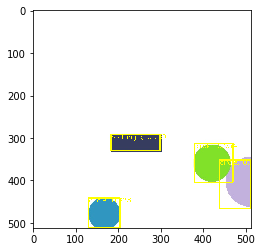

In [4]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 0
force_input_size = None  # set None to use default size
img_path = 'datasets/shape/val/999.jpg'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['rectangle', 'circle']

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/shape/efficientdet-d0_49_1400.pth'))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue

    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])

